In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities_ES as u



plt.rcParams['pdf.fonttype']=42
ko_mice = stx.ymaze_sess_deets.ko_mice

ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
# ctrl_mice = [m for m in ctrl_mice if m not in ('mCherry6')]

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
figdir = "C:/Users/esay/data/Stx3/fig_scratch/neural/"
os.makedirs(figdir,exist_ok=True)

In [64]:
spks = sess.timeseries['spks']
np.zeros_like(spks)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
def run_shuffle(sess, trial_starts, teleports,t, rng, trial_mask):
    spks = sess.timeseries['spks']
    spks_shuff = np.zeros(spks.shape)

    
    lr = sess.trial_info['LR'][trial_mask]
    
    # F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*spks[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        spks_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(spks_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    # return np.nanmean(tmat,axis=0)
    
    nov_mean = np.nanmean(tmat[lr==sess.novel_arm, :, :], axis=0)
    fam_mean = np.nanmean(tmat[lr==-1*sess.novel_arm, :, :], axis=0)

    # left_mean = np.nanmean(tmat[lr==-1, :, :], axis=0)
    # right_mean = np.nanmean(tmat[lr==1, :, :], axis=0)
    return nov_mean, fam_mean
    # return left_mean, right_mean

In [178]:
tmat.shape

(20, 30, 1048)

In [63]:
sess = u.load_single_day(mouse, day)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [66]:
trial_masks = sess.trial_matrices['downsample'][0:124]

In [67]:
sess.trial_start_inds.shape, trial_masks.shape

((124,), (124,))

In [68]:
trial_masks = sess.trial_matrices['downsample'][0:124]
starts, stops = sess.trial_start_inds[trial_masks], sess.teleport_inds[trial_masks]
starts, stops

(Int64Index([  367,  1065,  1595,  1993,  2440,  2627,  3597,  3796,  4022,
              4239,  5396,  5597,  5961,  6215,  6723,  6927,  7141,  7376,
              7805,  8008,  8188,  8380,  9148, 10682, 10968, 12157, 12366,
             12569, 12722, 12931, 13093, 13559, 13794, 14062, 14344, 14776,
             14981, 15209, 16326, 16791, 17044, 17472, 17652, 18324, 18490,
             18714, 19184, 19365, 19548, 19876, 20108, 20289, 20515, 22023,
             22215, 22415, 22598, 22771, 22992, 23371, 23546, 23904, 24120,
             24306, 24514, 24688, 24954, 25157, 25343, 25563, 26156, 26371,
             26750, 27247, 27421, 27794, 28675, 28853, 29311, 29540, 29725],
            dtype='int64'),
 Int64Index([  511,  1255,  1765,  2161,  2595,  2791,  3775,  3936,  4193,
              4456,  5575,  5757,  6148,  6404,  6902,  7081,  7295,  7533,
              7949,  8160,  8330,  8521,  9316, 10912, 11112, 12322, 12540,
             12703, 12886, 13081, 13269, 13735, 13960, 1425

In [69]:
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, starts, stops, sess.vr_data['t'], rng, trial_masks) for i in range(nperms)))
print(shuff_trial_mat.shape)
fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
shuff_results[mouse][day]['fam']=fam_shuff_thresh
shuff_results[mouse][day]['nov']=nov_shuff_thresh

(1000, 2, 30, 904)


In [72]:
shuff_results[mouse][day]['fam']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [137]:
# find trial mask 
rng = np.random.default_rng()
nperms = 1000

shuff_results = {}
for mice in (ctrl_mice, ko_mice):
    for mouse in mice:
        shuff_results[mouse]={}
        for day in range(6):
            try:
                sess = u.load_single_day(mouse, day)
            except FileNotFoundError:
                print(f"File not found for mouse {mouse}, day {day}. Skipping")
                continue
            except Exception as e:
                print(f"Error loading session for mouse {mouse} day {day}: {e}")
                continue 
                
            shuff_results[mouse][day] = {}
            

            trial_masks = sess.trial_matrices['downsample']
            try:
                starts, stops = sess.trial_start_inds[trial_masks], sess.teleport_inds[trial_masks]
            except IndexError as e:
                print(f'Indexing error for mouse {mouse}, day {day}: {e}. Skipping')
                continue
            except Exception as e:
                print(f"Unexpected error during trial masking for mouse {mouse} day {day}: {e}")
                continue
            
            shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, starts, stops, sess.vr_data['t'], rng, trial_masks) for i in range(nperms)))
            print(shuff_trial_mat.shape)
            fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
            nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
            shuff_results[mouse][day]['fam']=fam_shuff_thresh
            shuff_results[mouse][day]['nov']=nov_shuff_thresh

            # left_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
            # right_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
            # shuff_results[mouse][day]['left']=left_shuff_thresh
            # shuff_results[mouse][day]['right']=right_shuff_thresh

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


KeyboardInterrupt: 

In [176]:
shuff_trial_mat.shape

(100, 2, 30, 1048)

In [23]:
deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][day]
deets = deets[0]

### manually run on concat sessions

In [329]:
mouse = '4467975.1'
day = 0

deets = stx.ymaze_sess_deets.KO_sessions[mouse][day]
# deets = deets[0]
pkldir = os.path.join("C://Users/esay/data/Stx3/downsample_behavior_v4", mouse)
filename = os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session']))
with open(filename, 'rb') as file:
    sess = dill.load(file)

In [288]:
sess.timeseries.keys()

dict_keys(['F_dff', 'spks', 'F_dff_norm', 'spks_norm', 'licks', 'speed', 't', 'LR'])

In [320]:
timeseries_df = pd.DataFrame(sess.timeseries['t'].T)

In [321]:
timeseries_df[0]

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
33185    40.855019
33186    41.295879
33187    41.706099
33188    31.454580
33189    11.357900
Name: 0, Length: 33190, dtype: float64

In [293]:
sess.vr_data['t']

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
28577    41.296935
28578    41.538979
28579    41.824852
28580    40.309170
28581    11.282440
Name: t, Length: 28582, dtype: float64

In [335]:
trial_masks = trial_masks[0:124]
trial_masks.shape

sess.trial_matrices['downsample'] = trial_masks

In [336]:
nperms = 1000
shuff_results[mouse][day] = {}
            
trial_masks = sess.trial_matrices['downsample']
starts, stops = sess.trial_start_inds[trial_masks], sess.teleport_inds[trial_masks]
t = sess.vr_data['t'] #timeseries_df[0] 
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(sess, starts, stops, t, rng, trial_masks) for i in range(nperms)))
print(shuff_trial_mat.shape)
fam_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 1, :, :], 95, axis=0)
nov_shuff_thresh = np.nanpercentile(shuff_trial_mat[:, 0, :, :], 95, axis=0)
shuff_results[mouse][day]['fam']=fam_shuff_thresh
shuff_results[mouse][day]['nov']=nov_shuff_thresh

(1000, 2, 30, 904)


In [375]:
shuff_results[mouse][2]['fam']

array([[0.01319898, 0.0017702 , 0.02357369, ..., 0.00305604, 0.00362005,
        0.00801215],
       [0.01348492, 0.0025159 , 0.02484818, ..., 0.00185162, 0.00385794,
        0.00520131],
       [0.01597628, 0.00278725, 0.02762132, ..., 0.00238273, 0.00354741,
        0.00546151],
       ...,
       [0.01487025, 0.00405541, 0.0191855 , ..., 0.00293368, 0.00429947,
        0.0095442 ],
       [0.01445816, 0.00241606, 0.02190872, ..., 0.0023034 , 0.00424297,
        0.00807869],
       [0.00955757, 0.00327901, 0.02996022, ..., 0.0030925 , 0.00201703,
        0.00664721]])

In [385]:
ttype = 'fam'
mouse = '4467975.1'
day = 0

deets = stx.ymaze_sess_deets.KO_sessions[mouse][day]
# deets = stx.ymaze_sess_deets.CTRL_sessions[mouse][day]
# deets = deets[0]
pkldir = os.path.join("C://Users/esay/data/Stx3/downsample_behavior_v4", mouse)
filename = os.path.join(pkldir, deets['date'], "%s_%d.pkl" % (deets['scene'], deets['session']))
with open(filename, 'rb') as file:
    sess = dill.load(file)

    
downsample_mask = sess.trial_matrices['downsample']

    
if ttype == 'fam':
    trial_mask = (sess.trial_info['LR']==-1*sess.novel_arm) & downsample_mask # * (sess.trial_info['block_number']==5) 
elif ttype == 'nov':
    trial_mask = sess.trial_info['LR'] == sess.novel_arm & downsample_mask
else:
    pass

# sess.add_pos_binned_trial_matrix('speed')
speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
sig_bins = trial_avg>shuff_results[mouse][day][ttype]

# eliminate fields that start at first bin of track or end at last bin of track
field_info = []

ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
for _ledge in ledges:

    rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
    
    _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
    if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15):
        
        place_field = sess.trial_matrices['spks'][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
        
        speed_field = sess.trial_matrices['speed'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
        
        max_response = np.nanmax(place_field)
        place_field_filt = np.copy(place_field)
        place_field_filt[place_field<.2*max_response] = 0


        place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
        place_field_bin_counts = sp.signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



        thresh_laps = np.zeros(place_field_bool.shape)
        thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

        thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

        field_strength = np.nanmean(place_field,axis=-1)

        if thresh_active_laps.shape[0]>0:


            formation_lap = thresh_active_laps[0][0]
            pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
            if pcnt_trials_active>.66:

                # cell, left edge, right edge, formation lap, formation lap speed, avg speed
                field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:]), np.nanmean(speed_field[formation_lap:,:])])
                
                

com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
fwhm = np.nan*np.zeros([len(field_info)])

# df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
for c, (cell, l_edge, r_edge, formation_lap, _, _) in enumerate(field_info):
    # print(cell, l_edge, r_edge, formation_lap)

    place_field = sess.trial_matrices['spks'][trial_mask,  l_edge:l_edge+r_edge, cell]
    
    # pos = np.arange(place_field.shape[1])[np.newaxis,:]
    # com = (pos*place_field).sum(axis=1)/(place_field.sum(axis=1)+1E-5)
    # fig,ax = plt.subplots(1,2, sharey=True)
#         # ax[0].imshow(place_field[formation_lap:,:])

    com = []
    # maxact = []
    starts = sess.trial_start_inds[trial_mask]
    stops = sess.teleport_inds[trial_mask]
    for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
        
        pos = sess.timeseries['t'][0,start:stop]
        speed = sess.timeseries['speed'][0, start:stop]
        spks = np.copy(sess.timeseries['spks'][cell,start:stop])
        # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

        mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) & (speed>2)
        if mask.sum()>0:
            pos = pos[mask]
            spks = spks[mask]

            com.append((pos*spks).sum()/(spks.sum()+1E-5))
            # com.append(pos[np.argmax(spks)])
            
        else:
            com.append(np.nan)
            # maxact.append(np.nan)
            
        
    com_mat[:len(com), c] = np.array(com)
    # maxact_mat[:len(maxact),c] = np.array(maxact)
    
#         _com = np.nanmean(com[1:])
    mu_field = np.nanmean(place_field[formation_lap:,:], axis=0)
    field_max = np.amax(mu_field)
    
    cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))
    
    mu_field = (mu_field - cell_min)/(field_max - cell_min)
    
    l = 0
    while mu_field[l]<.5:
        l += 1
    
    
    r = 1
    while mu_field[-r]<.5:
        r += 1
    r -= 1
        
    fwhm[c] = r_edge -l - r

In [386]:
field_stats[mouse][day]={}
field_stats[mouse][day][ttype]={}
    
# field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
# field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype)
# df.append(_df)
field_stats[mouse][day][ttype]['field_info'] = field_info
field_stats[mouse][day][ttype]['com'] = com_mat
field_stats[mouse][day][ttype]['field_strength'] = fs_mat
# field_stats[mouse][day][ttype]['maxact'] = maxact_mat
field_stats[mouse][day][ttype]['fwhm'] = fwhm
field_stats[mouse][day][ttype]['speed'] = speed

In [387]:
field_stats[mouse][day][ttype]

{'field_info': [[49, 0, 10, 0, 45.04916085411903, 50.23657807247708],
  [240, 0, 5, 0, 48.61988996393562, 47.540244897039685],
  [307, 0, 5, 1, 43.06902287966044, 47.52363497293359],
  [319, 0, 4, 1, 43.25957451243139, 47.5259321962687],
  [325, 0, 4, 0, 50.08767196778887, 47.56474643523112],
  [418, 0, 5, 10, 34.336646535302755, 46.78726460423828],
  [439, 0, 6, 1, 43.26802310589354, 48.10587446540457],
  [457, 0, 5, 1, 43.06902287966044, 47.52363497293359],
  [461, 0, 9, 1, 44.24489400479801, 49.64419802628741],
  [512, 0, 11, 1, 45.736408519572166, 51.03217358050889],
  [545, 0, 7, 0, 46.89221588895848, 48.41922254983044],
  [598, 0, 4, 1, 43.25957451243139, 47.5259321962687],
  [626, 0, 6, 2, 40.334786645925334, 48.18146589289692],
  [628, 0, 4, 1, 43.25957451243139, 47.5259321962687],
  [675, 0, 12, 5, 56.60658683464516, 51.46892005349282],
  [703, 0, 7, 0, 46.89221588895848, 48.41922254983044],
  [731, 0, 5, 7, 59.51271662599851, 47.10447142016139],
  [791, 0, 11, 9, 54.596540755

### analysis

In [309]:
shuff_results.keys()

dict_keys(['4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1', 'mCherry6', 'mCherry7', 'mCherry8', 'mCherry9', '4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', 'Cre7', 'Cre9'])

In [327]:
import pickle
with open('C:/Users/esay/data/Stx3/downsample_behavior_v4/place_field_shuff_results.pkl','wb') as file:
    pickle.dump(shuff_results,file)

In [388]:
with open('C:/Users/esay/data/Stx3/downsample_behavior_v4/field_stats.pkl','wb') as file:
    pickle.dump(field_stats,file)

In [365]:
with open('C:/Users/esay/data/Stx3/downsample_behavior_v4/field_stats.pkl','rb') as file:
    field_stats = pickle.load(file)

In [312]:
import pickle 
with open('C:/Users/esay/data/Stx3/downsample_behavior_v4/place_field_shuff_results.pkl','rb') as file:
    shuff_results = pickle.load(file)

In [311]:
def get_field_info(mouse, day, ttype):
    if mouse in ctrl_mice:
        cond = 'ctrl'
    else:
        cond = 'cre'
        
    try:
        sess = u.load_single_day(mouse, day)
        downsample_mask = sess.trial_matrices['downsample']
    except FileNotFoundError:
        print(f"File not found for mouse {mouse}, day {day}. Skipping.")
        return None, None, None, None, None
    except Exception as e:
        print(f"Error loading session for mouse {mouse}, day {day}: {e}")
        return None, None, None, None, None
        
    if ttype == 'fam':
        trial_mask = (sess.trial_info['LR']==-1*sess.novel_arm) & downsample_mask # * (sess.trial_info['block_number']==5) 
    elif ttype == 'nov':
        trial_mask = sess.trial_info['LR'] == sess.novel_arm & downsample_mask
    else:
        pass

    # sess.add_pos_binned_trial_matrix('speed')
    speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
    trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)
    sig_bins = trial_avg>shuff_results[mouse][day][ttype]

    # eliminate fields that start at first bin of track or end at last bin of track
    field_info = []

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15):
            
            place_field = sess.trial_matrices['spks'][trial_mask,  _ledge[0]:_ledge[0]+_redge[0][0], _ledge[1]]
            
            speed_field = sess.trial_matrices['speed'][trial_mask, _ledge[0]:_ledge[0]+_redge[0][0]]
            
            max_response = np.nanmax(place_field)
            place_field_filt = np.copy(place_field)
            place_field_filt[place_field<.2*max_response] = 0


            place_field_bool = 1*(np.nansum(place_field_filt, axis=-1)>0)
            place_field_bin_counts = sp.signal.convolve(place_field_bool,[1,1,1,1,1], mode='valid')



            thresh_laps = np.zeros(place_field_bool.shape)
            thresh_laps[:place_field_bin_counts.shape[0]] = 1*(place_field_bin_counts>=3)

            thresh_active_laps = np.argwhere(thresh_laps*place_field_bool)

            field_strength = np.nanmean(place_field,axis=-1)

            if thresh_active_laps.shape[0]>0:


                formation_lap = thresh_active_laps[0][0]
                pcnt_trials_active = np.nanmean(place_field_bool[formation_lap:])
                if pcnt_trials_active>.66:

                    # cell, left edge, right edge, formation lap, formation lap speed, avg speed
                    field_info.append([_ledge[1], _ledge[0], _redge[0][0], formation_lap, np.nanmean(speed_field[formation_lap,:]), np.nanmean(speed_field[formation_lap:,:])])
                    
                    
    
    com_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    maxact_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fs_mat = np.nan*np.zeros([trial_mask.sum(), len(field_info)])
    fwhm = np.nan*np.zeros([len(field_info)])
    
    # df = {'mouse': [], 'cond':[], 'day':[], 'com':[], 'trial':[], 'cell': [], 'speed':[], 'ttype':[]}
    for c, (cell, l_edge, r_edge, formation_lap, _, _) in enumerate(field_info):
        # print(cell, l_edge, r_edge, formation_lap)

        place_field = sess.trial_matrices['spks'][trial_mask,  l_edge:l_edge+r_edge, cell]
        
        # pos = np.arange(place_field.shape[1])[np.newaxis,:]
        # com = (pos*place_field).sum(axis=1)/(place_field.sum(axis=1)+1E-5)
        # fig,ax = plt.subplots(1,2, sharey=True)
#         # ax[0].imshow(place_field[formation_lap:,:])

        com = []
        # maxact = []
        starts = sess.trial_start_inds[trial_mask]
        stops = sess.teleport_inds[trial_mask]
        for t, (start, stop) in enumerate(zip(starts[formation_lap:], stops[formation_lap:])):
            
            pos = sess.timeseries['t'][0,start:stop]
            speed = sess.timeseries['speed'][0, start:stop]
            spks = np.copy(sess.timeseries['spks'][cell,start:stop])
            # spks[spks<.2*np.nanmax(sess.timeseries['spks'][cell,:])] = 0

            mask = (pos>(l_edge + sess.trial_matrices['bin_edges'][0])) & (pos<(l_edge+r_edge + sess.trial_matrices['bin_edges'][0])) & (speed>2)
            if mask.sum()>0:
                pos = pos[mask]
                spks = spks[mask]

                com.append((pos*spks).sum()/(spks.sum()+1E-5))
                # com.append(pos[np.argmax(spks)])
                
            else:
                com.append(np.nan)
                # maxact.append(np.nan)
                
            
        com_mat[:len(com), c] = np.array(com)
        # maxact_mat[:len(maxact),c] = np.array(maxact)
        
#         _com = np.nanmean(com[1:])
        mu_field = np.nanmean(place_field[formation_lap:,:], axis=0)
        field_max = np.amax(mu_field)
        
        cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))
        
        mu_field = (mu_field - cell_min)/(field_max - cell_min)
        
        l = 0
        while mu_field[l]<.5:
            l += 1
        
        
        r = 1
        while mu_field[-r]<.5:
            r += 1
        r -= 1
            
        fwhm[c] = r_edge -l - r


    return field_info, com_mat, fs_mat, fwhm, speed #maxact_mat#, pd.DataFrame(df)

In [143]:
# shuff_results[ctrl_mice[0]][0]['fam']


field_stats = {}
df = []
for mouse in (ctrl_mice+ko_mice):
    # if mouse == "4467975.2" or "4467975.1":
    #     continue
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('fam', 'nov'):

            try:
                field_stats[mouse][day][ttype]={}
                
                # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
                field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype)
                # df.append(_df)
                field_stats[mouse][day][ttype]['field_info'] = field_info
                field_stats[mouse][day][ttype]['com'] = com_mat
                field_stats[mouse][day][ttype]['field_strength'] = fs_mat
                # field_stats[mouse][day][ttype]['maxact'] = maxact_mat
                field_stats[mouse][day][ttype]['fwhm'] = fwhm
                field_stats[mouse][day][ttype]['speed'] = speed
            except Exception as e:
                print(f"Error loading session for mouse {mouse}, day {day}: {e}")
                continue
            
# df = pd.DataFrame(df)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel'

C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:27: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:28: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}


C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:27: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:28: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
Error loading session for mouse 4467331.2, day 2: could not broadcast input array from shape (4,) into shape (2,)
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
Error loading session for mouse 4467331.2, day 3: expected str, bytes or os.PathLike object, not NoneType
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
Error loading session for mouse 4467331.2, day 3: expected str, bytes or os.PathLike object, not NoneType
{'date': '03_12_2020', 'scene': 'YMa

C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:122: RuntimeWarning: Mean of empty slice
  cell_min = np.amin(np.nanmean(sess.trial_matrices['spks'][trial_mask,  :, cell][formation_lap:,:], axis=0))


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
Error loading session for mouse 4467331.2, day 5: could not broadcast input array from shape (4,) into shape (2,)
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_12_2020', 'scene': 'YMaze_LN

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:27: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:28: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 's

C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:61: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}


C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:61: RuntimeWarning: Mean of empty slice
  field_strength = np.nanmean(place_field,axis=-1)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 3}


C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:27: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:28: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}


C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:27: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:28: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 

c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Error loading session for mouse 4467975.1, day 0: operands could not be broadcast together with shapes (124,) (144,) 
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Error loading session for mouse 4467975.1, day 0: operands could not be broadcast together with shapes (124,) (144,) 
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


Error loading session for mouse 4467975.2, day 3: could not broadcast input array from shape (4,) into shape (2,)
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/28_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}


c:\users\esay\repos\twoputils\TwoPUtils\sess.py:107: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:239: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
c:\users\esay\repos\twoputils\TwoPUtils\sess.py:248: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_006.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'sessio

C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:27: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(np.nanmean(sess.trial_matrices['speed'][trial_mask,:]))
C:\Users\esay\AppData\Local\Temp\ipykernel_56008\1385194187.py:28: RuntimeWarning: Mean of empty slice
  trial_avg = np.nanmean(sess.trial_matrices['spks'][trial_mask, :, :],axis=0)


{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '20_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
Error loading session for mouse Cre9, day 2: could not broadcast input array from shape (5,) into shape (1,)
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '21_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
Error loading session for mouse Cre9, day 3: could not broadcast input array from shape (4,) into shape (2,)
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '23_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 4}
Error loading session for mouse Cre9, day 4: could not broadcast input array from shape (4,) into shape (2,)
{'date': '23_10_2021', 'scene': 'YMaze_LNov

In [128]:
field_stats = {}
df = []
for mouse in (ctrl_mice+ko_mice):
    # if mouse == "4467975.2" or "4467975.1":
    #     continue
    field_stats[mouse] = {}
    for day in range(6):
        field_stats[mouse][day]={}
        for ttype in ('left', 'right'):
            field_stats[mouse][day][ttype]={}
            try:
                # field_info, com_mat, fs_mat, _df  = get_field_info(mouse, day, ttype)
                field_info, com_mat, fs_mat, fwhm, speed  = get_field_info(mouse, day, ttype)
                # df.append(_df)
                field_stats[mouse][day][ttype]['field_info'] = field_info
                field_stats[mouse][day][ttype]['com'] = com_mat
                field_stats[mouse][day][ttype]['field_strength'] = fs_mat
                # field_stats[mouse][day][ttype]['maxact'] = maxact_mat
                field_stats[mouse][day][ttype]['fwhm'] = fwhm
                field_stats[mouse][day][ttype]['speed'] = speed
            except Exception as e:
                print(f"Error loading session for mouse {mouse}, day {day}: {e}")
                continue

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
Error loading session for mouse 4467331.1, day 0: 'left'
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
Error loading session for mouse 4467331.1, day 0: local variable 'trial_mask' referenced before assignment
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
Error loading session for mouse 4467331.1, day 1: 'left'
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
Error loading session for mouse 4467331.1, day 1: local variable 'trial_mask' referenced before assignment
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}


KeyboardInterrupt: 

In [146]:
df = {'mouse': [],
      'cond': [],
      'ttype': [],
      'day': [],
      'field_width': [],
      'fwhm': [],
      'n_fields': [],
      'speed': []}
      

lw = 5
s = 10

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice,ko_mice)):
    for mouse in mice:
        for day in range(6):
            print(mouse, day)
            for ttype in ('fam', 'nov'):

                try: 
                    df['mouse'].append(mouse)
                    df['cond'].append(cond)
                    df['ttype'].append(ttype)
                    df['day'].append(day)
    
                    f_info = np.array(field_stats[mouse][day][ttype]['field_info'])
    
                    df['field_width'].append(f_info[:,2].mean())
                    df['fwhm'].append(field_stats[mouse][day][ttype]['fwhm'].mean())
                    
                    
                    
                    cell_list = np.unique(f_info[:,0])
                    df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())
                    df['speed'].append(field_stats[mouse][day][ttype]['speed'].mean())

                except IndexError as e:
                    print(f"Skipping mouse {mouse}, day {day}, type {ttype} due to IndexError: {e}")
                    continue
                except KeyError as k:
                    print(f"Skipping mouse {mouse}, day {day}, type {ttype} due to KeyError: {k}")
                    continue
                
df = pd.DataFrame(df)

4467331.1 0
4467331.1 1
4467331.1 2
4467331.1 3
4467331.1 4
4467331.1 5
4467331.2 0
Skipping mouse 4467331.2, day 0, type nov due to IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed
4467331.2 1
Skipping mouse 4467331.2, day 1, type nov due to IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed
4467331.2 2
Skipping mouse 4467331.2, day 2, type nov due to KeyError: 'field_info'
4467331.2 3
Skipping mouse 4467331.2, day 3, type fam due to IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed
Skipping mouse 4467331.2, day 3, type nov due to IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed
4467331.2 4
4467331.2 5
Skipping mouse 4467331.2, day 5, type nov due to KeyError: 'field_info'
4467332.1 0
4467332.1 1
4467332.1 2
4467332.1 3
4467332.1 4
Skipping mouse 4467332.1, day 4, type nov due to IndexError: too many indices for array: array is 1-dimensional, but 2 were 

ValueError: All arrays must be of the same length

In [156]:
mouse = '4467331.2'
day = 0
ttype = 'nov'
field_stats[mouse][day][ttype]['field_info']

[]

In [372]:
field_stats


2

In [389]:
df = {'mouse': [],
      'cond': [],
      'ttype': [],
      'day': [],
      'field_width': [],
      'fwhm': [],
      'n_fields': [],
      'speed': []}

lw = 5
s = 10

for cond, mice in zip(('ctrl', 'cre'), (ctrl_mice, ko_mice)):
    for mouse in mice:
        for day in range(6):
            for ttype in ('fam', 'nov'):
                try:
                    f_info = np.array(field_stats[mouse][day][ttype]['field_info'])

                    field_width = f_info[:, 2].mean()
                    fwhm = field_stats[mouse][day][ttype]['fwhm'].mean()

                    cell_list = np.unique(f_info[:, 0])
                    n_fields = np.array([np.count_nonzero(f_info[:, 0] == cell) for cell in cell_list]).mean()
                    speed = field_stats[mouse][day][ttype]['speed'].mean()

                    df['mouse'].append(mouse)
                    df['cond'].append(cond)
                    df['ttype'].append(ttype)
                    df['day'].append(day)
                    df['field_width'].append(field_width)
                    df['fwhm'].append(fwhm)
                    df['n_fields'].append(n_fields)
                    df['speed'].append(speed)

                except Exception as e:
                    print(f"Skipping mouse {mouse}, day {day}, type {ttype} due to error: {e}")
                    continue

df = pd.DataFrame(df)


Skipping mouse 4467331.2, day 0, type nov due to error: too many indices for array: array is 1-dimensional, but 2 were indexed
Skipping mouse 4467331.2, day 1, type nov due to error: too many indices for array: array is 1-dimensional, but 2 were indexed
Skipping mouse 4467331.2, day 2, type nov due to error: 'nov'
Skipping mouse 4467331.2, day 3, type nov due to error: 'nov'
Skipping mouse 4467331.2, day 5, type nov due to error: 'field_info'
Skipping mouse 4467332.1, day 4, type nov due to error: too many indices for array: array is 1-dimensional, but 2 were indexed
Skipping mouse 4467332.2, day 1, type nov due to error: 'nov'
Skipping mouse mCherry6, day 3, type nov due to error: too many indices for array: array is 1-dimensional, but 2 were indexed
Skipping mouse mCherry8, day 3, type nov due to error: too many indices for array: array is 1-dimensional, but 2 were indexed
Skipping mouse mCherry8, day 4, type nov due to error: too many indices for array: array is 1-dimensional, but 2

In [394]:
ctrl_mice

('4467331.1',
 '4467331.2',
 '4467332.1',
 '4467332.2',
 '4467333.1',
 'mCherry6',
 'mCherry7',
 'mCherry8',
 'mCherry9')

[100.  50.  50. ...  40.  30.  40.]
[80. 70. 90. ... 30. 30. 30.]
[ 30. 120. 120. ...  40.  40.  40.]
[120.  60. 110. ...  50.  40.  40.]
[110. 100. 120. ...  30.  30.  30.]
[100. 110. 110. ...  30.  30.  30.]
Familiar ANOVA
        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0         cond  3.780549    1   14  3.780549  3.539781  0.080872        NaN   
1          day  1.172242    4   56  0.293060  1.760767  0.149682   0.194829   
2  Interaction  1.062726    4   56  0.265681  1.596269  0.188037        NaN   

        np2       eps sphericity  W-spher   p-spher  
0  0.201814       NaN        NaN      NaN       NaN  
1  0.111718  0.582361      False  0.23472  0.022583  
2  0.102349       NaN        NaN      NaN       NaN  
      Contrast day    A     B Paired  Parametric         T        dof  \
0          day   -    0     1   True        True -1.714570  15.000000   
1          day   -    0     2   True        True -1.221326  15.000000   
2          day   -    0

C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)
C:\Users\esay\.conda\envs\s2p_analysis\lib\site-packages\pingouin\parametric.py:1572: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  aov = pd.concat([aov_betw.drop(1), aov_with.drop(1)], axis=0, sort=False, ignore_index=True)


        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0         cond  4.553969    1    5  4.553969  6.628730  0.049755        NaN   
1          day  1.084119    4   20  0.271030  0.810998  0.532858   0.436162   
2  Interaction  0.807437    4   20  0.201859  0.604021  0.664223        NaN   

        np2       eps sphericity   W-spher  p-spher  
0  0.570030       NaN        NaN       NaN      NaN  
1  0.139563  0.450373      False  0.008113  0.01697  
2  0.107783       NaN        NaN       NaN      NaN  
      Contrast day    A     B Paired  Parametric         T       dof  \
0          day   -    0     1   True        True -0.904027  6.000000   
1          day   -    0     2   True        True -1.379470  6.000000   
2          day   -    0     3   True        True -0.912528  6.000000   
3          day   -    0     4   True        True -0.697836  6.000000   
4          day   -    0     5   True        True -1.388755  6.000000   
5          day   -    1     2   Tru

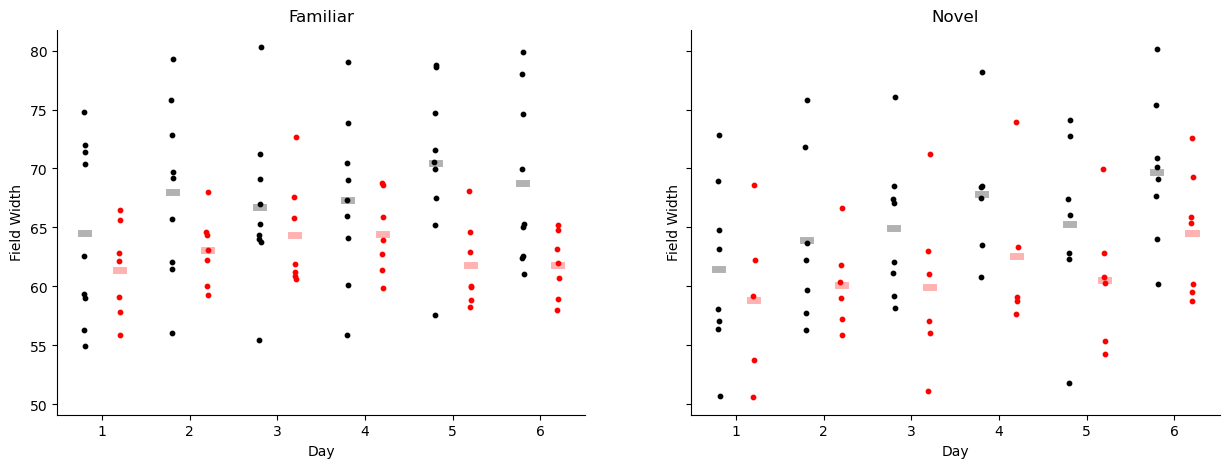

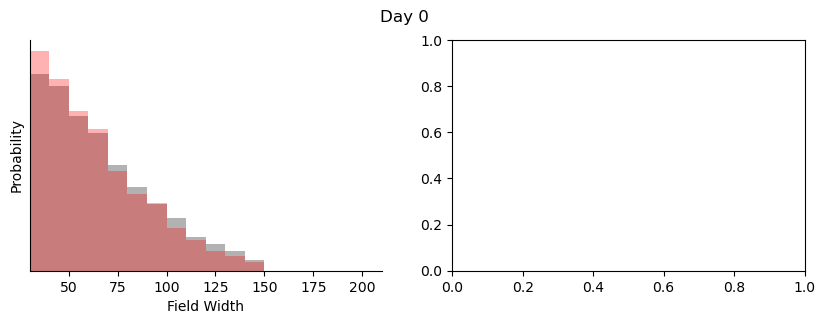

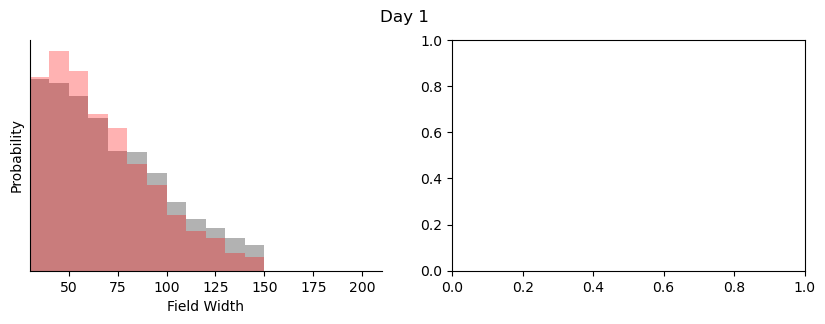

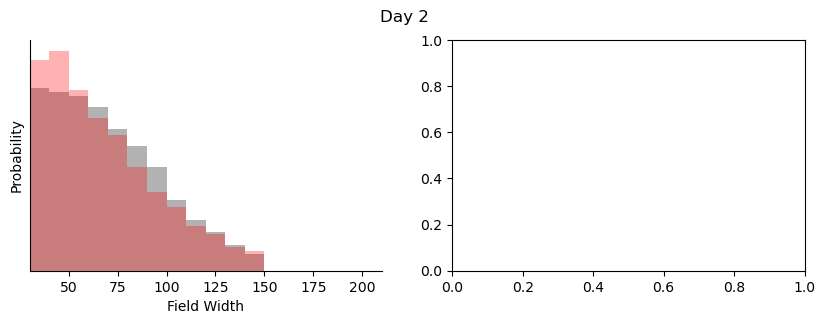

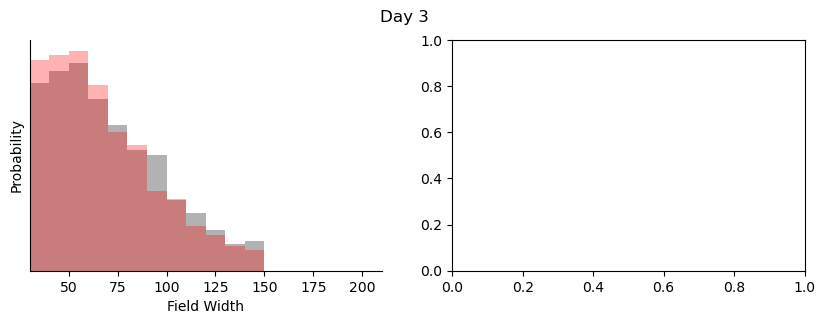

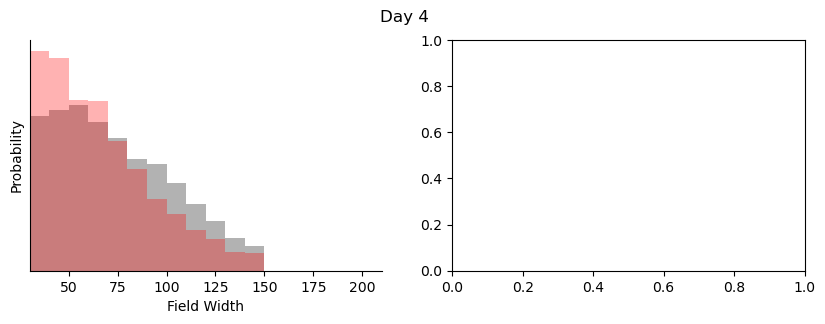

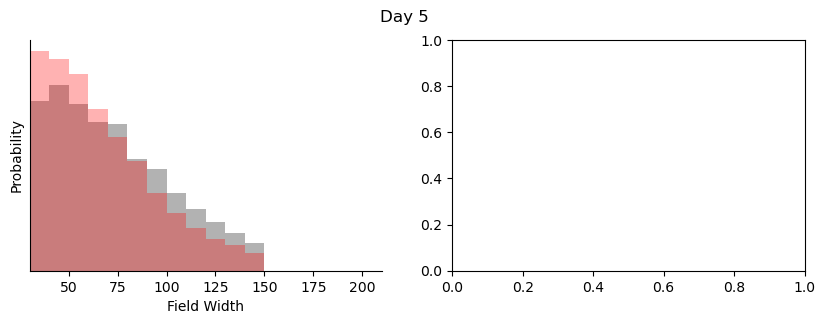

In [390]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    fw = 10.*df['field_width'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=fw.shape[0]), fw, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), fw.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('Field Width')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "field_width_across_mouse_summary.pdf"))


# single day, across mouse histograms
bin_edges = np.arange(30,210, 10)
for day in range(6):
    
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        try: 
            ctrl_width = []
            for mouse in ctrl_mice:
                f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
                ctrl_width.append(f_info[:,2].ravel())
                # ctrl_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
                
            ctrl_width = np.concatenate(ctrl_width)
            
            ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
            
            ko_width = []
            for mouse in ko_mice:
                f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
                ko_width.append(f_info[:,2].ravel())
                # ko_width.append(10*field_stats[mouse][day][ttype]['field_width'].ravel())
                
            ko_width = np.concatenate(ko_width)
            print(ko_width)
        except:
            continue
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('Field Width')
        ax[ax_ind].set_xlim(30,210)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_field_width_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='fam'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='field_width', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[df['ttype']=='nov'], dv='field_width', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

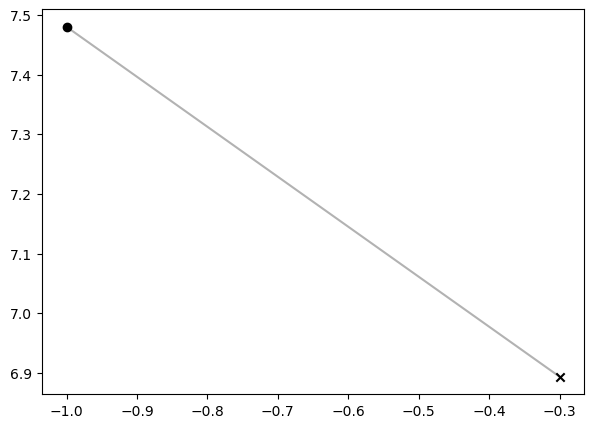

In [391]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['field_width'].loc[_df['ttype']=='fam']._values, _df['field_width'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Field Width')
ax.set_xlabel('Day')
    
# fig.savefig(os.path.join(figdir,"log_activity_rate_summary_within_group.pdf"),format='pdf')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

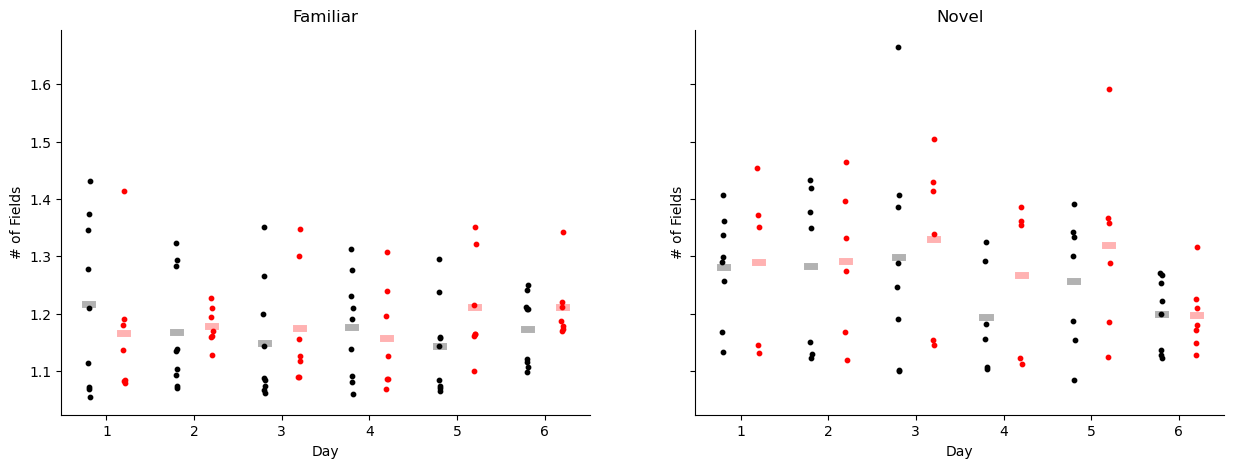

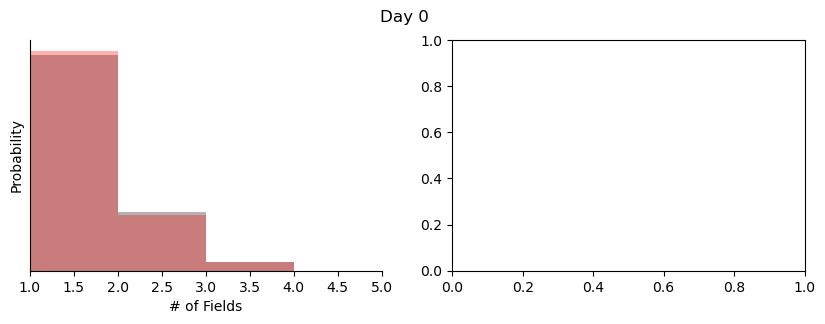

In [395]:
fig, ax = plt.subplots(1,2, figsize=[15,5], sharey=True)

# population plots
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s)
    ax[0].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='ctrl') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day -1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='black', s=s, alpha = 1)
    ax[1].plot(5*day -1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='black', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='fam')
    nf = df['n_fields'].loc[mask]._values
    ax[0].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s)
    ax[0].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    
    mask = (df['cond']=='cre') & (df['day']==day) & (df['ttype']=='nov')
    nf = df['n_fields'].loc[mask]._values
    ax[1].scatter(5*day +1 + np.linspace(-0.05, 0.05, num=nf.shape[0]), nf, color='red', s=s, alpha=1)
    ax[1].plot(5*day + 1 + np.array([-0.2, .2]), nf.mean()*np.ones([2,]), color='red', linewidth=lw,alpha = .3)
    

ax[0].set_title('Familiar')
ax[1].set_title('Novel')
    
for a in range(2):

    ax[a].set_xticks(np.arange(0,6*5,5))
    ax[a].set_xticklabels([x for x in range(1,7)])

    ax[a].spines['top'].set_visible(False)
    ax[a].spines['right'].set_visible(False)

    ax[a].set_ylabel('# of Fields')
    ax[a].set_xlabel('Day')
# fig.savefig(os.path.join(figdir, "num_fields_across_mouse_summary.pdf"))



# single day, across mouse histograms
bin_edges = np.arange(0,5, 1)
for day in range(6):
    fig, ax = plt.subplots(1,2, figsize = [10,3])
    fig.suptitle(f'Day {day}')
    for ax_ind, ttype in enumerate(('fam', 'nov')):
        
        ctrl_width = []
        for mouse in ctrl_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
            
            ctrl_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
            
        ctrl_width = np.concatenate(ctrl_width)
        
        ax[ax_ind].hist(ctrl_width, bins=bin_edges, color='black', alpha=.3, density=True)
        
        ko_width = []
        for mouse in ko_mice:
            f_info = 10*np.array(field_stats[mouse][day][ttype]['field_info'])
            cell_list = np.unique(f_info[:,0])
                
            ko_width.append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).ravel())
            
        ko_width = np.concatenate(ko_width)
        ax[ax_ind].hist(ko_width, bins=bin_edges, color='red', alpha=.3, density=True)
        

        ax[ax_ind].spines['top'].set_visible(False)
        ax[ax_ind].spines['right'].set_visible(False)
    
        ax[ax_ind].set_yticks([])
        ax[ax_ind].set_ylabel('Probability')
        ax[ax_ind].set_xlabel('# of Fields')
        ax[ax_ind].set_xlim(1,5)
        
        # fig.savefig(os.path.join(figdir, f"day{day}_num_fields_hist.pdf"))


print('Familiar ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='fam') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='fam')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)

print('Novel ANOVA')
aov = mixed_anova(data=df.loc[(df['ttype']=='nov') & (df['day']<5)], dv='n_fields', between='cond', within='day', subject='mouse')
print(aov)

posthoc = pairwise_tests(data=df.loc[(df['ttype']=='nov')], dv='n_fields', between='cond', within='day', subject='mouse', padjust = 'holm')
print(posthoc)



Text(0.5, 0, 'Day')

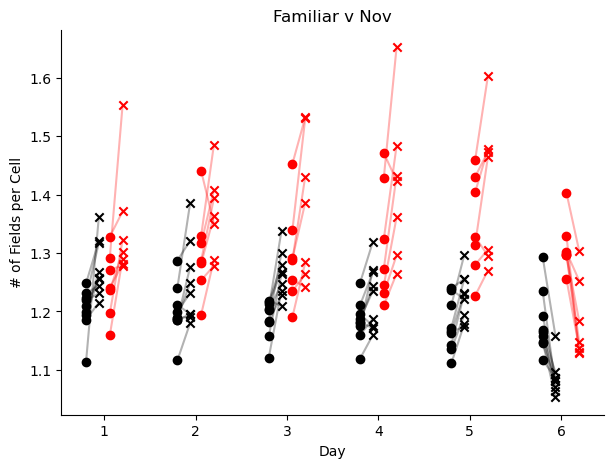

In [12]:
fig, ax = plt.subplots(figsize=[7,5], sharey=True)

lw = 5
s = 10
for day in range(6):
    
    mask = (df['cond']=='ctrl') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ctrl_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        # ax[0].scatter(5*day + np.array([-1,-.3]), lr, color='black', alpha = .3)
        ax.scatter(5*day - 1,lr[0], color='black', alpha = 1, marker='o')
        ax.scatter(5*day - .3, lr[1], color='black', alpha = 1, marker='x')
        
    mask = (df['cond']=='cre') & (df['day']==day) #& (df['fam/nov']=='fam')
    for mouse in ko_mice:
        _mask = mask & (df['mouse']==mouse)
        _df = df[_mask]
        lr = [_df['n_fields'].loc[_df['ttype']=='fam']._values, _df['n_fields'].loc[_df['ttype']=='nov']._values]
        
        ax.plot(5*day + np.array([.3,1]), lr, color='red', alpha = .3)
        ax.scatter(5*day + .3,lr[0], color='red', alpha = 1, marker='o')
        ax.scatter(5*day + 1, lr[1], color='red', alpha = 1, marker='x')

# ax.plot([-2.3, 27.3], [0, 0], 'k--', zorder= -1, alpha=.5)

    
ax.set_title('Familiar v Nov')

ax.set_xticks(np.arange(0,6*5,5))
ax.set_xticklabels([x for x in range(1,7)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('# of Fields per Cell')
ax.set_xlabel('Day')